In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import os
import sys
import copy

# Add src to path
sys.path.append("src")
import kmeans
import utils

## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

In this lab  we segment the given image using K-means clustering.

## Theory and implementation


## Code organization
**Date**: `data`

**Source code**: `src`

# Result

### Import data and visualize.

In [76]:
car = cv.imread('data/car.png')
flower = cv.imread('data/flower.png')

In [81]:
car_arr = utils.get_pixel_array(car)
c_init = np.array([[255, 0, 0], [0, 0, 0], [255, 255, 255]]).T
cluster_assignment, clusters, cost = kmeans.kmeans(car_arr, 3, c_init, max_iters = 5)
for i in range(car_arr.shape[1]):
    car_arr[:, i] = clusters[:, cluster_assignment[i]]
car_segmented = utils.get_image(car_arr, car.shape[0], car.shape[1])

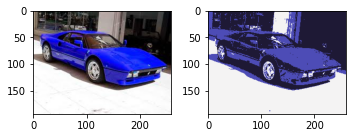

In [82]:
fig, axs =plt.subplots(1, 2, figsize=(5, 10))
axs[0].imshow(car)
axs[1].imshow(car_segmented)
fig.tight_layout()